<a href="https://colab.research.google.com/github/HammadN98/Pos-Inteligencia-Artificial-e-Computacional/blob/main/Topicos-Especiais-IA/Topicos_Especiais_Relatorio_1_ES119826.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
url_treino = 'https://raw.githubusercontent.com/HammadN98/Pos-Inteligencia-Artificial-e-Computacional/refs/heads/main/Topicos-Especiais-IA/dados/titanic/train.csv'
url_teste = 'https://raw.githubusercontent.com/HammadN98/Pos-Inteligencia-Artificial-e-Computacional/refs/heads/main/Topicos-Especiais-IA/dados/titanic/test.csv'
url_sub = 'https://raw.githubusercontent.com/HammadN98/Pos-Inteligencia-Artificial-e-Computacional/refs/heads/main/Topicos-Especiais-IA/dados/titanic/gender_submission.csv'

In [4]:
dados = pd.read_csv(url_treino)
dados.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
dados.shape

(891, 12)

## Pre-Processamento

In [6]:
dados.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
dados['Age'].median(), dados['Age'].min(), dados['Age'].max()

(28.0, 0.42, 80.0)

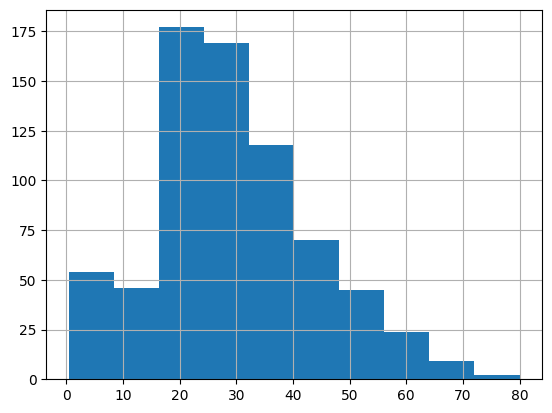

In [8]:
dados['Age'].hist();

COnsiderando que a distribuicao se assemelha a uma distribuicao normal, os dado faltantes serao imputados por sua mediana.

In [9]:
dados['Age'] = dados['Age'].fillna(dados['Age'].median())

### Embarked

Como sao poucos valores faltantes serao imputados pelo mais frequente.

In [10]:
dados['Embarked'].value_counts()

,count
Embarked,
S,644
C,168
Q,77


In [11]:
dados['Embarked'] = dados['Embarked'].fillna('S')

In [12]:
cattonum = {'S': 1,
            'C': 2,
            'Q': 3}
dados['Embarked'] = dados['Embarked'].replace(cattonum).astype(int)


<ipython-input-12-33838c92a823>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados['Embarked'] = dados['Embarked'].replace(cattonum).astype(int)


### Cabin

A variavel da cabine tem quase 2/3 de valores ausentes. Porem antes de remover-la eu irei usar para criar uma variavel se possui cabine registrada ou nao.

In [13]:
dados['Cabin'].isnull().sum()

687

In [14]:
dados['Cabine_verificada'] = dados['Cabin'].notnull().astype(int)

# Remover a coluna original
dados = dados.drop(columns=['Cabin'])

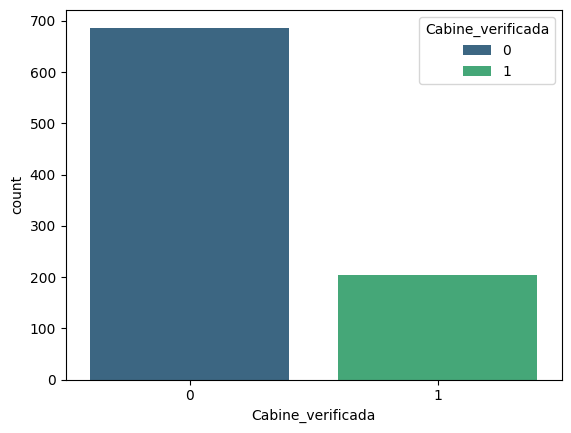

In [15]:
sns.countplot(data=dados, x=dados['Cabine_verificada'], hue='Cabine_verificada', palette='viridis');

### Sex

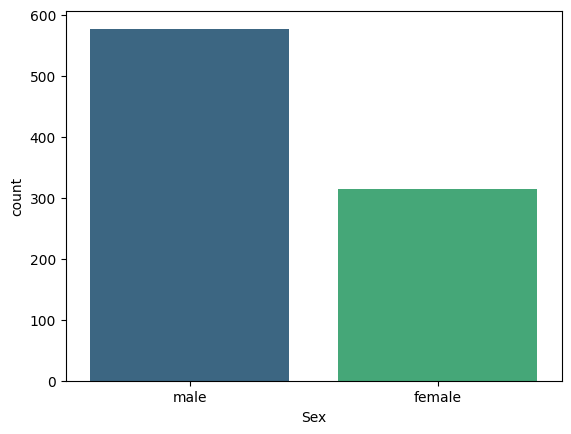

In [16]:
sns.countplot(data=dados, x=dados['Sex'], hue='Sex', palette='viridis');

In [17]:
encoder = OneHotEncoder(drop='first', sparse_output=False) #objeto

encoded = encoder.fit_transform(dados[['Sex']]) #Transformando a variuavel

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Sex'])) #Guardando as outras varivais, para hora do test

dados = dados.join(encoded_df).drop(columns=['Sex']) #Juntando tudo

### Survived

In [18]:
dados['Survived'].value_counts()

,count
Survived,
0,549
1,342


Esta classe desbalanceada possivelmente afetara os resultados. Caso nao se tome nenhuma medida.
Primeiro iremos modelar sem o tratamento, e caso os resultados parecam estar prejudicados com a dieferenca, usaremos SMOTE.

In [19]:
549 / (549 + 346)

0.6134078212290502

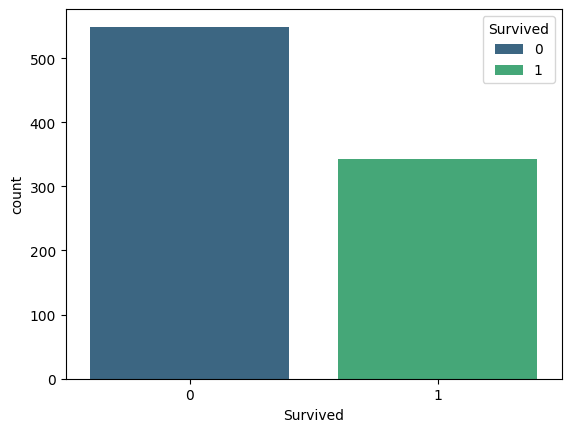

In [20]:
sns.countplot(data=dados, x=dados['Survived'], hue='Survived', palette='viridis');

## Remocao

Variaveis que naop serao utilizadas.
- Name
- Ticket
- PassengerId

In [21]:
dados = dados.drop(columns=['PassengerId', 'Name', 'Ticket']) #variaveis nao numericas, ou Identificadoras

In [22]:
dados.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Cabine_verificada', 'Sex_male'],
      dtype='object')

## Duplicando a base

Iremos copiar os dados, para manter duas bases, uma escalonado e outra nao. Cada qual para seu tipo de algoritimo.

1. Nao escalonados = Decision Tree, Random Forest e XGBoost
2. Escalonados = KNN e SVM

* Pois modelos arvores nao necessitam dos dados padronizados

In [23]:
dados_scaled = dados.copy()

scaler = StandardScaler() #Numeircas contginuas
dados_scaled[['Age', 'Fare', 'Pclass']] = scaler.fit_transform(dados_scaled[['Age', 'Fare', 'Pclass']])

In [24]:
dados_scaled.shape, dados.shape

((891, 9), (891, 9))

## Separando os dados

In [25]:
y_train = dados['Survived']

X_train = dados.drop(columns=['Survived'])
X_train_sc = dados_scaled.drop(columns=['Survived'])

In [26]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Cabine_verificada,Sex_male
0,3,22.0,1,0,7.2500,1,0,1.0
1,1,38.0,1,0,71.2833,2,1,0.0
2,3,26.0,0,0,7.9250,1,0,0.0
3,1,35.0,1,0,53.1000,1,1,0.0
4,3,35.0,0,0,8.0500,1,0,1.0


In [27]:
X_train_sc

,Pclass,Age,SibSp,Parch,Fare,Embarked,Cabine_verificada,Sex_male
0,0.827377,-0.565736,1,0,-0.502445,1,0,1.0
1,-1.566107,0.663861,1,0,0.786845,2,1,0.0
2,0.827377,-0.258337,0,0,-0.488854,1,0,0.0
3,-1.566107,0.433312,1,0,0.420730,1,1,0.0
4,0.827377,0.433312,0,0,-0.486337,1,0,1.0
...,...,...,...,...,...,...,...,...
886,-0.369365,-0.181487,0,0,-0.386671,1,0,1.0
887,-1.566107,-0.796286,0,0,-0.044381,1,1,0.0
888,0.827377,-0.104637,1,2,-0.176263,1,0,0.0
889,-1.566107,-0.258337,0,0,-0.044381,2,1,1.0


## Modelos e Validacao cruzada

In [28]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [29]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#Decision Tree
dt = DecisionTreeClassifier(random_state=0)
scores_dt = cross_val_score(dt, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Media do Decision Tree: {scores_dt.mean():.3f}")

#Random Forest
rf = RandomForestClassifier(random_state=0)
scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Media do Random Forest: {scores_rf.mean():.3f}")

#XGBoost
xgb = XGBClassifier(random_state = 0)
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Media do XGBoost: {scores_xgb.mean():.3f}")

#KNN
knn = KNeighborsClassifier()
scores_knn = cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring='accuracy') #Sensivel a escala
print(f"Media do KNN: {scores_knn.mean():.3f}")

#SVM
svm = SVC(decision_function_shape='ovo')
scores_svm = cross_val_score(svm, X_train_sc, y_train, cv=kf, scoring='accuracy') #Sensivel a escala
print(f"Media do SVM: {scores_svm.mean():.3f}")

Media do Decision Tree: 0.781
Media do Random Forest: 0.807
Media do XGBoost: 0.809
Media do KNN: 0.791
Media do SVM: 0.822


### Decision Tree

In [30]:
dt = DecisionTreeClassifier(random_state=0)
scores_dt = cross_val_score(dt, X_train, y_train, cv=kf, scoring='accuracy')

print(scores_dt.mean())

0.7811122967798632


### Random Forest

In [31]:
rf = RandomForestClassifier(random_state=0)
scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
print(scores_rf.mean())

0.8069361621994853


### XGBoost

In [32]:
xgb = XGBClassifier(random_state = 0)
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='accuracy')
print(scores_xgb.mean())

0.8091833532107213


### KNN

In [33]:
knn = KNeighborsClassifier()
scores_knn = cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring='accuracy')
print(scores_knn.mean())

0.7912183792605612


### SVM

In [34]:
svm = SVC(decision_function_shape='ovo', random_state = 0)
scores_svm = cross_val_score(svm, X_train_sc, y_train, cv=kf, scoring='accuracy')
print(scores_svm.mean())

0.8215303496327915


## Hyperparametros

Os modelos que passaram de 80% serao hyperparametrados, para ver qua performa melhor.

Sera usado GridCV para o modelo de RandomForest pois como os hyperparamnro nao sao complexos nao ira demorar demasiadamente.

Ja para os modelos XGBoost e SVM, como podem a vir ter tempos de procura com o GridCV muito alto, iremos usar o gp_minimize.

### Random Forest Hyper

In [35]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("RandomForest - Melhor hiperparâmetro:", grid_search_rf.best_params_)
print(f"Melhor acurácia: {grid_search_rf.best_score_:.4f}")

RandomForest - Melhor hiperparâmetro: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Melhor acurácia: 0.8272


### XGBoost Hyper

In [36]:
# Definição do espaço de busca
space_xgb = [
    Integer(50, 500, name="n_estimators"),
    Integer(3, 15, name="max_depth"),
    Real(0.01, 0.3, name="learning_rate"),
    Integer(1, 10, name="min_child_weight"),
]

# Função objetivo
@use_named_args(space_xgb)
def objective_xgb(**params):
    model = XGBClassifier(**params, random_state=42, eval_metric='logloss')
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return 1 - score  # Minimiza (1 - acurácia)

# Execução da otimização
res_xgb = gp_minimize(objective_xgb, space_xgb, n_calls=30, random_state=42)

# Melhores hiperparâmetros
print("XGBoost - Melhor hiperparâmetro:", res_xgb.x)
print(f"Melhor acurácia encontrada: {1 - res_xgb.fun:.4f}")


XGBoost - Melhor hiperparâmetro: [99, 8, 0.1787603794528352, 5]
Melhor acurácia encontrada: 0.8395


### SVM Hyper

In [37]:
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.svm import SVC

# Definição do espaço de busca

space_svm = [
    Real(0.01, 10, name="C"),
    Real(0.001, 5, name="gamma"),
    Categorical(["linear", "rbf"], name="kernel"),
]

# Função objetivo
@use_named_args(space_svm)
def objective_svm(**params):
    model = SVC(**params)
    score = cross_val_score(model, X_train_sc, y_train, cv=3, scoring='accuracy').mean()
    return 1 - score  # Minimiza (1 - acurácia)

# Execução da otimização
res_svm = gp_minimize(objective_svm, space_svm, n_calls=20, random_state=42)

# Melhores hiperparâmetros
print("SVM - Melhor hiperparâmetro:", res_svm.x)
print(f"Melhor acurácia encontrada: {1 - res_svm.fun:.4f}")


SVM - Melhor hiperparâmetro: [2.053559932626155, 0.30625132061443394, 'rbf']
Melhor acurácia encontrada: 0.8204


### TReinanado os  dois melhores modelos com os melhores hyperparametros e comparando-os.

In [38]:
# Random Forest
random_best = {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
rf = RandomForestClassifier(random_state=0, **random_best)
modelo_rf = rf.fit(X_train, y_train,)
#print(f"Random Forest Tunado: {scores_rf.mean()}")

#XGBoost
xgb_best = { "n_estimators": 99, "max_depth": 8, "learning_rate": 0.1787603794528352, "min_child_weight": 5}
xgb = XGBClassifier(random_state = 0, **xgb_best)
modelo_xgb = xgb.fit( X_train, y_train)
#print(f"XGB Tunado: {scores_xgb.mean()}")

#svm_best = { "C": 2.053559932626155, "gamma": 0.30625132061443394, "kernel": "rbf"}
#svm = SVC(random_state = 0, **svm_best)
#modelo_svm = svm.fit(X_train_sc, y_train)


In [39]:
# Random Forest
random_best = {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
rf = RandomForestClassifier(random_state=0, **random_best)
modelo_rf = rf.fit(X_train, y_train,)


#XGBoost
xgb_best = { "n_estimators": 99, "max_depth": 8, "learning_rate": 0.1787603794528352, "min_child_weight": 5}
xgb = XGBClassifier(random_state = 0, **xgb_best)
modelo_xgb = xgb.fit( X_train, y_train)


### Prevendo

In [40]:
#REalizando todas as transformacoes nos dados de test. E retornando uma base escalonada e a nao/
def transforma(dados):
  dados['Age'] = dados['Age'].fillna(dados['Age'].median())
  dados['Fare'] = dados['Fare'].fillna(dados['Fare'].median())
  dados['Embarked'] = dados['Embarked'].fillna('S')
  cattonum = {'S': 1,
            'C': 2,
            'Q': 3}
  dados['Embarked'] = dados['Embarked'].replace(cattonum).astype(int)

  dados['Cabine_verificada'] = dados['Cabin'].notnull().astype(int)
  dados = dados.drop(columns=['Cabin'])

  encoder = OneHotEncoder(drop='first', sparse_output=False) #objeto
  encoded = encoder.fit_transform(dados[['Sex']]) #Transformando a variuavel
  encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Sex'])) #Guardando as outras varivais, para hora do test
  dados = dados.join(encoded_df).drop(columns=['Sex']) #Juntando tudo

  dados = dados.drop(columns=['PassengerId', 'Name', 'Ticket']) #variaveis nao numericas, ou Identificadoras
  X_test = dados.copy()
  return X_test

X_teste = pd.read_csv(url_teste)
X_test =  transforma(X_teste)

<ipython-input-40-540ba5cc9142>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados['Embarked'] = dados['Embarked'].replace(cattonum).astype(int)


COnsiderando que estes dois modelo foram melhores, e eu quero usar um sistema de votacao. COm a quantidade de modelos para eles podem ficar epatados, porem como a grande maioria dos dados tem o valor 0, irei definir como regra que quando os modelos empatarem, a resposta sera 0.

In [41]:
def submissao(num_sub:int, y_pred): #FUncao para criar a submisao
  submission = pd.DataFrame({
    "PassengerId": X_teste['PassengerId'],
    "Survived": y_pred
  })
  sub = submission.to_csv(f"submission{num_sub}.csv", index=False)

  print(f"Arquivo de submissão salvo como 'submission{num_sub}.csv'.")
  return sub


In [42]:
pred_rf = modelo_rf.predict(X_test)
pred_xgb = modelo_xgb.predict(X_test)

y_pred = np.where(pred_rf == pred_xgb, pred_rf, 0) #"Votacao" simples.

submissao(1, y_pred)

sub1 = 0.75837
print(f"submission: Score:{sub1} na competicao" )

Arquivo de submissão salvo como 'submission1.csv'.
submission: Score:0.75837 na competicao


In [43]:
pred_rf = modelo_rf.predict(X_test)
pred_xgb = modelo_xgb.predict(X_test)

y_pred = np.where(pred_rf == pred_xgb, pred_rf, 0) #"Votacao" simples.

submissao(1, y_pred)

Arquivo de submissão salvo como 'submission1.csv'.


### Submisao 2

Para as proxima submissoes criar uma classe para realizar todas transformacos necessarias. Alem da necessarias, como agora iremos usar tres modelos, com o votting Classifier, os dados seram escalonados, devido a necessidade do SVM.

In [44]:
class TitanicPreprocessor:
    def __init__(self):
        self.encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        self.scaler = StandardScaler()
        self.cattonum = {'S': 1, 'C': 2, 'Q': 3}
        self.fitted = False

    def fit(self, X, y=None):  # Adicionando y=None para compatibilidade com o Scikit-learn
        X = X.copy()

        # Tratamento de valores faltantes (para treino)
        X['Age'] = X['Age'].fillna(X['Age'].median())
        X['Fare'] = X['Fare'].fillna(X['Fare'].median())
        X['Embarked'] = X['Embarked'].fillna('S')

        # Ajustar a conversão categórica no treino
        X['Embarked'] = X['Embarked'].replace(self.cattonum).astype(int)

        # Ajuste para variáveis categóricas (OneHotEncoder)
        self.encoder.fit(X[['Sex']])  # Só faz fit no treino

        # Ajuste do scaler (Normalização)
        num_cols = ['Age', 'Fare']
        self.scaler.fit(X[num_cols])  # Apenas no treino

        self.fitted = True
        return self  # Retorna o próprio objeto para permitir encadeamento

    def transform(self, X):
        if not self.fitted:
            raise ValueError("O Preprocessor precisa ser ajustado primeiro com fit() antes de chamar transform()")

        X = X.copy()

        if 'Survived' in X:
            X = X.drop(columns=['Survived'])

        # Tratamento de valores faltantes (para teste)
        X['Age'] = X['Age'].fillna(X['Age'].median())  # Usa a mediana do teste
        X['Fare'] = X['Fare'].fillna(X['Fare'].median())
        X['Embarked'] = X['Embarked'].fillna('S')

        # Conversão categórica
        X['Embarked'] = X['Embarked'].replace(self.cattonum).astype(int)

        # Feature Engineering
        X['Cabine_verificada'] = X['Cabin'].notnull().astype(int)
        X = X.drop(columns=['Cabin'])

        # OneHotEncoding (garantindo que os dummies fiquem iguais ao treino)
        encoded = self.encoder.transform(X[['Sex']])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(['Sex']), index=X.index)
        X = X.join(encoded_df).drop(columns=['Sex'])

        # Normalizar dados numéricos
        num_cols = ['Age', 'Fare']
        X[num_cols] = self.scaler.transform(X[num_cols])

        # Remover colunas desnecessárias
        X = X.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')

        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [46]:
X_train = pd.read_csv(url_treino)
X_test = pd.read_csv(url_teste)

In [47]:
preprocessor = TitanicPreprocessor()

# Ajustar
preprocessor.fit(X_train)

#PRocessar
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

<ipython-input-44-f463826915f9>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Embarked'] = X['Embarked'].replace(self.cattonum).astype(int)
<ipython-input-44-f463826915f9>:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Embarked'] = X['Embarked'].replace(self.cattonum).astype(int)
<ipython-input-44-f463826915f9>:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the futur

In [49]:
# Random Forest
random_best = {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
rf = RandomForestClassifier(random_state=0, **random_best)
modelo_rf = rf.fit(X_train_proc, y_train,)


#XGBoost
xgb_best = { "n_estimators": 99, "max_depth": 8, "learning_rate": 0.1787603794528352, "min_child_weight": 5}
xgb = XGBClassifier(random_state = 0, **xgb_best)
modelo_xgb = xgb.fit(X_train_proc, y_train)


svm_best = { "C": 2.053559932626155, "gamma": 0.30625132061443394, "kernel": "rbf"}
svm = SVC(random_state = 0, **svm_best)
modelo_svm = svm.fit(X_train_proc, y_train)

In [50]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(
    estimators=[
        ('rf', modelo_rf),
        ('xgb', modelo_xgb),
        ('svm', modelo_svm)
    ],
    voting='hard' # "hard" = maioria dos votos
)

voting_clf.fit(X_train_proc, y_train)

y_pred_VC = voting_clf.predict(X_test_proc)

In [51]:
submissao(2, y_pred_VC)

sub2 = 0.76794
print(f"submission: Score: {sub2} na competicao" )

Arquivo de submissão salvo como 'submission2.csv'.
submission: Score: 0.76794 na competicao


In [52]:
sub2 = 0.76794
sub1 = 0.75837
print(f"Fomos de {sub1} na primeira tentativa, para {sub2} na segunda. Tendo uma diferneca de {sub2 - sub1}")

Fomos de 0.75837 na primeira tentativa, para 0.76794 na segunda. Tendo uma diferneca de 0.009569999999999967


## Submissao 3

Como era de se esperar a faltya de precisao nao vem dos modelos, pois a diferenca obtida usando mais um modelo e menor que 0.01. Logo vamos voltar aos dados. Como sabemos que os mesmo sao desbalanceados, vamos usar a tecnica SMOTE para dar uma balanceada nos dados e iremos submeter a votacao com 3 modelos + SMOTE

In [54]:
# Classe criada para transformar dados
X_train_proc = TitanicPreprocessor().fit_transform(X_train)

# SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=0)
X_train_bal, y_train_bal = smote.fit_resample(X_train_proc, y_train)

modelo_rf.fit(X_train_bal, y_train_bal)
modelo_xgb.fit(X_train_bal, y_train_bal)
modelo_svm.fit(X_train_bal, y_train_bal)

<ipython-input-44-f463826915f9>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Embarked'] = X['Embarked'].replace(self.cattonum).astype(int)
<ipython-input-44-f463826915f9>:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Embarked'] = X['Embarked'].replace(self.cattonum).astype(int)


SVC(C=2.053559932626155, gamma=0.30625132061443394, random_state=0)

In [55]:
# Criando o ensemble de votação majoritária (hard voting)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', modelo_rf),
        ('xgb', modelo_xgb),
        ('svm', modelo_svm)
    ],
    voting='hard'
)

voting_clf.fit(X_train_bal,y_train_bal)

y_pred_VC_SMOTE = voting_clf.predict(X_test_proc)

In [56]:
submissao(3, y_pred_VC_SMOTE)
sub3 = 0.77511
print(f"submission: Score: {sub3} na competicao" )

Arquivo de submissão salvo como 'submission3.csv'.
submission: Score: 0.77511 na competicao


In [57]:
resultados = [
    {"Modelo" : "XGBoost + RandomForest != 0", "Score": 0.75837},
    {"Modelo" : "+ SVM + VotingClassifier", "Score": 0.76794},
    {"Modelo" : "+ SMOTE", "Score": 0.77511}
]
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Score
0,XGBoost + RandomForest != 0,0.75837
1,+ SVM + VotingClassifier,0.76794
2,+ SMOTE,0.77511
